In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
# https://github.com/rohan-paul/MachineLearning-DeepLearning-Code-for-my-YouTube-Channel/blob/master/Finance_Stock_Crypto_Trading/Credit_Suisse_Price_Prediction_with_GRU/OUTPUT.ipynb

In [2]:
df = pd.read_csv('NFLX.csv')
df
df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
df.head()

,date,open,high,low,close,adj_close,volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
print("Total number of days: ",df.shape[0])
print("Total number of fields: ",df.shape[1])


Total number of days:  1009
Total number of fields:  7


In [4]:
print("Null values:", df.isnull().values.sum())
print("NA values:", df.isna().values.any())

Null values: 0
NA values: False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1009 non-null   object 
 1   open       1009 non-null   float64
 2   high       1009 non-null   float64
 3   low        1009 non-null   float64
 4   close      1009 non-null   float64
 5   adj_close  1009 non-null   float64
 6   volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [6]:
df['date'] = pd.to_datetime(df['date'], utc=True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       1009 non-null   datetime64[ns, UTC]
 1   open       1009 non-null   float64            
 2   high       1009 non-null   float64            
 3   low        1009 non-null   float64            
 4   close      1009 non-null   float64            
 5   adj_close  1009 non-null   float64            
 6   volume     1009 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 55.3 KB


In [8]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2018-02-05 00:00:00+00:00
Ending date:  2022-02-04 00:00:00+00:00
Duration:  1460 days 00:00:00


In [9]:
df_close = df[['date','close']]

df_close_original = df_close.copy()

print("Shape of close dataframe:", df_close.shape)
df_close

Shape of close dataframe: (1009, 2)


,date,close
0,2018-02-05 00:00:00+00:00,254.259995
1,2018-02-06 00:00:00+00:00,265.720001
2,2018-02-07 00:00:00+00:00,264.559998
3,2018-02-08 00:00:00+00:00,250.100006
4,2018-02-09 00:00:00+00:00,249.470001
...,...,...
1004,2022-01-31 00:00:00+00:00,427.140015
1005,2022-02-01 00:00:00+00:00,457.130005
1006,2022-02-02 00:00:00+00:00,429.480011
1007,2022-02-03 00:00:00+00:00,405.600006


In [10]:
training_size=int(len(df_close)*0.80)

test_size=len(df_close)-training_size

train_data,test_data = df_close[0:training_size],df_close[training_size:len(df_close)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

train_data:  (807, 2)
test_data:  (202, 2)


In [11]:
del train_data['date']
del test_data['date']

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(df_close.shape)


(1009, 2)


In [13]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
time_step = 7
X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (799, 7)
y_train:  (799,)
X_test:  (194, 7)
y_test (194,)


In [15]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 32)             3360      
                                                                 
 gru_1 (GRU)                 (None, 7, 32)             6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
# history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=16,verbose=1)
history = model.fit(X_train,y_train,epochs=50,batch_size=16,verbose=1)

Epoch 1/50
50/50 [==============================] - 3s 5ms/step - loss: 0.0430
Epoch 2/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 3/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 4/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 5/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 6/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 7/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 8/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 9/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 10/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 11/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 12/50
50/50 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 13/50
50/50 [==============================

In [18]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape
X_test

7/7 [==============================] - 0s 2ms/step


array([[0.78028704, 0.77994659, 0.7707824 , ..., 0.7707824 , 0.77353449,
        0.78057078],
       [0.77994659, 0.7707824 , 0.78425911, ..., 0.77353449, 0.78057078,
        0.79325299],
       [0.7707824 , 0.78425911, 0.7707824 , ..., 0.78057078, 0.79325299,
        0.78088283],
       ...,
       [0.46422285, 0.4348578 , 0.37604267, ..., 0.43358111, 0.42694198,
        0.54831753],
       [0.4348578 , 0.37604267, 0.35697668, ..., 0.42694198, 0.54831753,
        0.63340517],
       [0.37604267, 0.35697668, 0.43358111, ..., 0.54831753, 0.63340517,
        0.55495657]])

In [19]:
test_predict

array([[0.78378105],
       [0.79625905],
       [0.78534347],
       [0.76795053],
       [0.748334  ],
       [0.75658864],
       [0.7697185 ],
       [0.72528213],
       [0.74098   ],
       [0.7191827 ],
       [0.71965134],
       [0.73799455],
       [0.72854984],
       [0.71899945],
       [0.72207284],
       [0.7589475 ],
       [0.7537041 ],
       [0.76389974],
       [0.76148593],
       [0.76375467],
       [0.768523  ],
       [0.766461  ],
       [0.75621486],
       [0.7558237 ],
       [0.7307572 ],
       [0.7416924 ],
       [0.7441079 ],
       [0.73750204],
       [0.71923053],
       [0.72102165],
       [0.726084  ],
       [0.7551542 ],
       [0.7375186 ],
       [0.7348766 ],
       [0.75117636],
       [0.75994   ],
       [0.7502333 ],
       [0.7796708 ],
       [0.7939625 ],
       [0.8080529 ],
       [0.83298975],
       [0.85086644],
       [0.8526425 ],
       [0.8381511 ],
       [0.85260963],
       [0.8561636 ],
       [0.8768989 ],
       [0.862

In [20]:
train_predict = scaler.inverse_transform(train_predict)

test_predict = scaler.inverse_transform(test_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 

original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [21]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

Train data RMSE:  10.742140960648172
-------------------------------------------------------------------------------------
Test data RMSE:  13.34371334826565


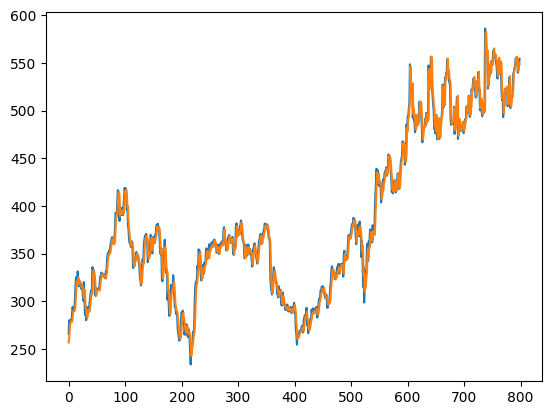

In [22]:
import matplotlib.pyplot as plt

plt.plot(original_ytrain)
plt.plot(train_predict)
plt.show()

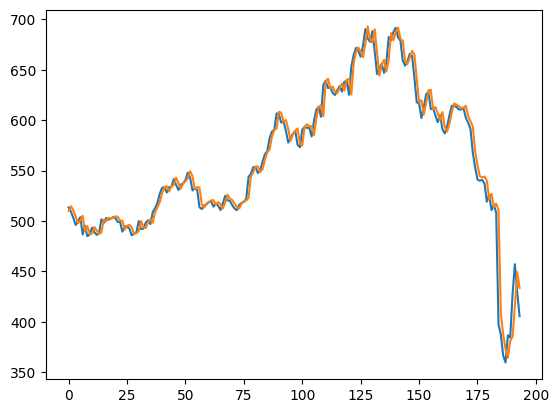

In [23]:


plt.plot(original_ytest)
plt.plot(test_predict)
plt.show()